# Rate change per press release

In this file we combine the press conference text data with changes on ECB key rates, assigning each text a value representing the (average) change in the rates. For example if in june 2023 DFR rate was 3.25 and in july 2023 the same rate was 3.50, the june's conference had a negative effect of -0.25.

In [47]:
import pandas as pd

press_releases = pd.read_csv('../ecb_scraper/outputs/clean_text_excl_nums.csv')
key_rates = pd.read_csv('../ecb_euribor_correlation/ECB Data Portal_20231016130234.csv')

# Merge press_releases and key_rates on date
press_releases['date'] = pd.to_datetime(press_releases['date'])
key_rates['date'] = pd.to_datetime(key_rates['DATE'])
merged = press_releases.merge(key_rates, on='date', how='left')

data = merged.drop(columns=['DATE', 'TIME PERIOD'])
data = data.rename(columns={data.columns[2]: 'DFR', data.columns[3]: 'MLF', data.columns[4]: ' MRO'})
data = data.dropna()

# Calculate the change in key rates
data['DFR_change'] = data['DFR'].diff()
data['MLF_change'] = data['MLF'].diff()
data['MRO_change'] = data[' MRO'].diff()
data['AVG_change'] = data[['DFR_change', 'MLF_change', 'MRO_change']].mean(axis=1)

policy_effect = data[['date', 'text', 'AVG_change']]
policy_effect.to_csv('policy_change_rates.csv', index=False)

decreasing_rates = policy_effect[policy_effect['AVG_change'] > 0]
increasing_rates = policy_effect[policy_effect['AVG_change'] < 0]

decreasing_rates.to_csv('decreasing_rates.csv', index=False)
increasing_rates.to_csv('increasing_rates.csv', index=False)

After splitting the text data, we can look for most common words in each data set to potentially find meaningful words relating to their effect on interest rates.

In [48]:
from collections import Counter

dec_words = (" ".join(decreasing_rates['text']).split())
inc_words = (" ".join(increasing_rates['text']).split())

dec_most_common = Counter(dec_words).most_common(10)
inc_most_common = Counter(inc_words).most_common(10)

print("Most common words in transcripts with rate decreasing effect:")
print(dec_most_common, "\n")

print("Most common words in transcripts with rate increasing effect:")
print(inc_most_common)

Most common words in transcripts with rate decreasing effect:
[('rate', 1013), ('question', 996), ('euro', 634), ('price', 550), ('inflat', 548), ('area', 545), ('bank', 540), ('govern', 509), ('growth', 461), ('market', 432)] 

Most common words in transcripts with rate increasing effect:
[('rate', 1315), ('question', 1033), ('price', 985), ('inflat', 926), ('euro', 704), ('growth', 676), ('monetari', 667), ('polici', 612), ('market', 547), ('risk', 540)]


We see here no significant differences yet, despite for the fact that word "inflat" appeared ~40% more in the transcript with increasing effect, and word "risk" is not present in the top 10 list of transcript with decreasing effect, unlinke in the other set. We now proceed to remove some frequent words that are common in both data sets using rather naive method.

In [49]:
from collections import Counter
import string

dec_most_common = Counter(dec_words).most_common(1500)
inc_most_common = Counter(inc_words).most_common(1500)

dec_common_words = [word for word, count in dec_most_common]
inc_common_words = [word for word, count in inc_most_common]

# Set of common words that appear in both data sets
common_words = set(dec_common_words).intersection(inc_common_words)

def remove_common_words(text):
    text = text.split()
    text = [word for word in text if word not in common_words]
    text = " ".join(text)
    return text

# Directly manipulate the text columns in the original data set
policy_effect['text'] = policy_effect['text'].apply(remove_common_words)

# Recreate split data
decreasing_rates = policy_effect[policy_effect['AVG_change'] > 0]
increasing_rates = policy_effect[policy_effect['AVG_change'] < 0]

dec_words = (" ".join(decreasing_rates['text']).split())
inc_words = (" ".join(increasing_rates['text']).split())

dec_most_common = Counter(dec_words).most_common(10)
inc_most_common = Counter(inc_words).most_common(10)

print("Most common words in transcripts with rate decreasing effect:")
print(dec_most_common[:10], "\n")

print("Most common words in transcripts with rate increasing effect:")
print(inc_most_common)

Most common words in transcripts with rate decreasing effect:
[('draghi', 217), ('deflat', 71), ('nonstandard', 60), ('ab', 49), ('turmoil', 43), ('net', 36), ('packag', 35), ('subdu', 35), ('intensif', 33), ('fragment', 30)] 

Most common words in transcripts with rate increasing effect:
[('cent', 162), ('hike', 121), ('tpi', 55), ('normalis', 47), ('neutral', 40), ('withdraw', 37), ('datadepend', 33), ('counter', 32), ('paus', 29), ('elev', 28)]


/tmp/ipykernel_37520/1566585234.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  policy_effect['text'] = policy_effect['text'].apply(remove_common_words)


Now we can see more differentiation in the common words. 

Let's continue by applying TF/IDF analysis on the datasets.

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

dec_doc = (" ").join(decreasing_rates['text'])
inc_doc = (" ").join(increasing_rates['text'])

corpus = [dec_doc, inc_doc]

vectorizer = TfidfVectorizer(smooth_idf=True, sublinear_tf=True)
X = vectorizer.fit_transform(corpus)

K = 10

print("Words with highest TF/IDF in transcripts followed by decreasing rates:")

idx_dec = np.flip(np.argsort(X[0, :].A)[0][-K:])
dec_scores = np.flip(np.sort(X[0, :].A)[0][-K:])
dec_words = vectorizer.get_feature_names_out()[idx_dec]

for i in range(10):
    print(f'{i+1: <3} {dec_words[i]: <13} {"{:.4f}".format(dec_scores[i])}')

print("\nWords with highest TF/IDF in transcripts followed by increasing rates:")

idx_inc = np.flip(np.argsort(X[1, :].A)[0][-K:])
inc_scores = np.flip(np.sort(X[1, :].A)[0][-K:])
inc_words = vectorizer.get_feature_names_out()[idx_inc]

for i in range(10):
    print(f'{i+1: <3}{inc_words[i]: <13} {"{:.4f}".format(dec_scores[i])}')


Words with highest TF/IDF in transcripts followed by decreasing rates:
1   ab            0.0713
2   draghi        0.0662
3   qe            0.0615
4   securitis     0.0603
5   sluggish      0.0550
6   deflat        0.0546
7   unlimit       0.0541
8   nonstandard   0.0529
9   trap          0.0520
10  sme           0.0520

Words with highest TF/IDF in transcripts followed by increasing rates:
1  tpi           0.0713
2  datadepend    0.0662
3  cent          0.0615
4  steadi        0.0603
5  ga            0.0550
6  meetingbymeet 0.0546
7  ukrain        0.0541
8  hike          0.0529
9  termin        0.0520
10 slovenia      0.0520


This result seems slightly gibberish, and we can conclude that more defined text preprocessing could give us more meaningful results. However, for the scope of this project, we'll settle for this result.

To further analyse the given text data, we can fit the data into a logistic regression model.

/tmp/ipykernel_37520/1772990976.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  policy_effect['label'] = policy_effect['AVG_change'].apply(label_change)


Accuracy: 0.83


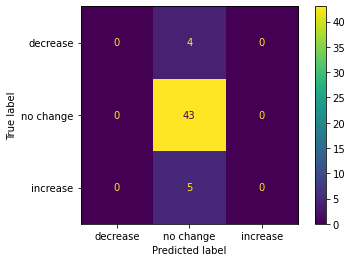

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


model = LogisticRegression()

def label_change(x):
    if x > 0:
        return 1
    elif x < 0:
        return -1
    else:
        return 0
    
# Create a ternary label column
policy_effect['label'] = policy_effect['AVG_change'].apply(label_change)

X_train, X_test, y_train, y_test = train_test_split(policy_effect["text"], policy_effect['label'], test_size=0.2, random_state=i)

vectorizer = TfidfVectorizer(smooth_idf=True, sublinear_tf=True)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

lr_model = LogisticRegression()
lr_model.fit(X_train_tfidf, y_train)

y_pred = lr_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
success_rates.append(accuracy)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["decrease", "no change", "increase"])
disp.plot()
plt.show()

The data points where there is no change in the interest rate seems to be heavily represent in the data, resulting our model predicting all test input as "no change". To avoid this, let's drop the "no change" rows, and compare only the rows that had an change in the interest rates.

Accuracy: 0.82


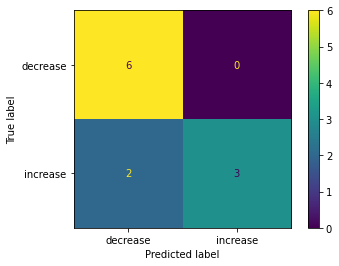

Accuracy: 0.82


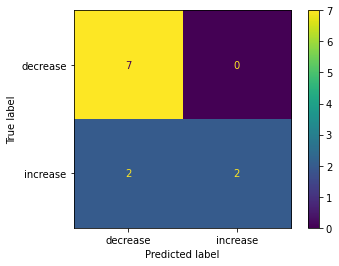

Accuracy: 1.00


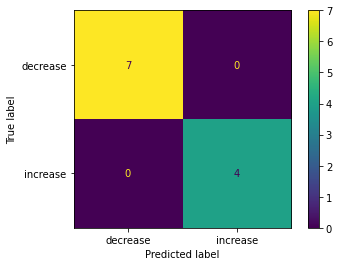

Accuracy: 0.82


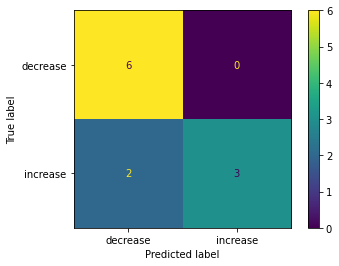

Accuracy: 0.82


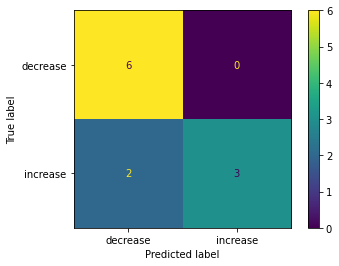

Average accuracy: 0.85


In [52]:
# Drop rows where AVG_change = 0 to give more weight on the increase/decrease effect
policy_effect = policy_effect[policy_effect['AVG_change'] != 0]
    
# Convert the AVG_change column to a binary label column
policy_effect['label'] = policy_effect['AVG_change'].apply(lambda x: 1 if x > 0 else 0)

success_rates = []

# Run test logistic regression 5 times with different random states
for i in range(5): 
    X_train, X_test, y_train, y_test = train_test_split(policy_effect["text"], policy_effect['label'], test_size=0.2, random_state=i)

    vectorizer = TfidfVectorizer(smooth_idf=True, sublinear_tf=True)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    lr_model = LogisticRegression()
    lr_model.fit(X_train_tfidf, y_train)

    y_pred = lr_model.predict(X_test_tfidf)

    accuracy = accuracy_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.2f}")

    success_rates.append(accuracy)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["decrease", "increase"])
    disp.plot()
    plt.show()

print(f"Average accuracy: {np.mean(success_rates):.2f}")

We can now get more accurate results when we dropped out the data points where there was no change in the rates. With logistic regression model we can now predict the correct direction with a 0.85 average. Perhaps further preprocessing of the text data could've let in better results in the ternary comparison.